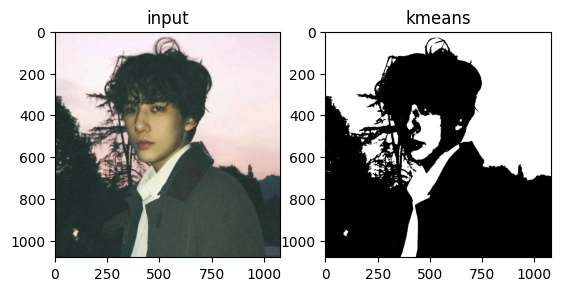

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def seg_kmeans_color():
    img = cv2.imread('1.jpg', cv2.IMREAD_COLOR)
    # 变换一下图像通道bgr->rgb，否则很别扭啊
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    # 3个通道展平
    img_flat = img.reshape((img.shape[0] * img.shape[1], 3))
    img_flat = np.float32(img_flat)

    # 迭代参数
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_MAX_ITER, 20, 0.5)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # 聚类
    compactness, labels, centers = cv2.kmeans(img_flat, 2, None, criteria, 10, flags)

    # 显示结果
    img_output = labels.reshape((img.shape[0], img.shape[1]))
    plt.subplot(121), plt.imshow(img), plt.title('input')
    plt.subplot(122), plt.imshow(img_output, 'gray'), plt.title('kmeans')
    plt.show()
    
    # 5. 模型评估 - silhouette 轮廓系数评估，越接近1越好
    #print("SC：", silhouette_score(data, data_predict))
seg_kmeans_color()

In [3]:
import math
import numpy as np
 
 
def euler_distance(point1, point2):
    distance = 0.0
    for a, b in zip(point1, point2):
        distance += math.pow(a-b, 2)
    return math.sqrt(distance)
 
 
# 定义聚类树的节点
class ClusterNode:
    def __init__(self, vec, left=None, right=None, distance=-1, id=None, count=1):
        """
        vec: 保存两个数据merge后新的中心
        left: 左节点
        right: 右节点
        distance: 两个节点的距离
        id: 保存哪个节点是计算过的
        count: 这个节点的叶子节点个数
        """
        self.vec = vec
        self.left = left
        self.right = right
        self.distance = distance
        self.id = id
        self.count = count
 
 
# 层次聚类的类
# 不同于文中所说的先构建树，再进行切分，而是直接根据所需类别数目，聚到满足条件的节点数量即停止
# 和k-means一样，也需要指定类别数量
class Hierarchical:
    def __init__(self, k=1):
        assert k > 0
        self.k = k
        self.labels = None
 
    def fit(self, x):
        # 初始化节点各位等于数据的个数
        nodes = [ClusterNode(vec=v, id=i) for i, v in enumerate(x)]
        distance = {}
        point_num, feature_num = np.shape(x)
        self.labels = [-1] * point_num
        currentclustid = -1
        while len(nodes) > self.k:
            min_dist = np.inf
            # 当前节点的个数
            nodes_len = len(nodes)
            # 最相似的两个类别
            closest_part = None
            # 当前节点中两两距离计算，找出最近的两个节点
            for i in range(nodes_len-1):
                for j in range(i+1, nodes_len):
                    # 避免重复计算
                    d_key = (nodes[i].id, nodes[j].id)
                    if d_key not in distance:
                        distance[d_key] = euler_distance(nodes[i].vec, nodes[j].vec)
                    d = distance[d_key]
                    if d < min_dist:
                        min_dist = d
                        closest_part = (i, j)
            part1, part2 = closest_part
            node1, node2 = nodes[part1], nodes[part2]
            # 将两个节点进行合并,即两个节点所包含的所有数据的平均值
            new_vec = [(node1.vec[i] * node1.count + node2.vec[i] * node2.count) / (node1.count + node2.count)
                       for i in range(feature_num)]
            new_node = ClusterNode(vec=new_vec, left=node1, right=node2, distance=min_dist, id=currentclustid,
                                   count=node1.count + node2.count)
            currentclustid -= 1
            # 删掉这最近的两个节点
            del nodes[part2], nodes[part1]
            # 把新的节点添加进去
            nodes.append(new_node)
        # 树建立完成，这里要注意，在示例中是最终凝聚为1个节点，而这里到达所要指定的类别数目即停止，一个node属于一个类别
        self.nodes = nodes
        # 给每个node以及node包含的数据打上标签
        self.calc_label()
 
    def calc_label(self):
        # 调取聚类结果
        for i, node in enumerate(self.nodes):
            self.leaf_traversal(node, i)
 
    def leaf_traversal(self, node: ClusterNode, label):
        # 递归遍历叶子结点
        if node.left is None and node.right is None:
            self.labels[node.id] = label
        if node.left:
            self.leaf_traversal(node.left, label)
        if node.right:
            self.leaf_traversal(node.right, label)